In [1]:
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(14, 8))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Conceitos básicos e decomposição de Séries Temporais + Feature Engineering

## Importando os dados a serem utilizados

In [2]:
import pandas as pd

df = pd.read_csv('train.csv',parse_dates=['date'])
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


Como podemos ver, os dados estão organizados da seguinte forma: temos uma tabela em que cada dia vemos:

- Dia (do começo de 2013 até 15-8-2017)
- Código da loja (54 no total)
- Gênero do produto 
- Número de vendas desse produto, dessa categoria, nesse dia
- Se os produtos em venda estavam na promoção

Para transformar isso em um DataFrame que possamos usar, precisamos utilizar algumas ferramentas do pandas

In [3]:
df = df.set_index('date').to_period('D')

In [4]:
df

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0
2013-01-01,1,1,BABY CARE,0.000,0
2013-01-01,2,1,BEAUTY,0.000,0
2013-01-01,3,1,BEVERAGES,0.000,0
2013-01-01,4,1,BOOKS,0.000,0
...,...,...,...,...,...
2017-08-15,3000883,9,POULTRY,438.133,0
2017-08-15,3000884,9,PREPARED FOODS,154.553,1
2017-08-15,3000885,9,PRODUCE,2419.729,148


In [5]:
df = df.set_index(['store_nbr', 'family'], append=True)

In [6]:
df

id     sales  \
date       store_nbr family                                          
2013-01-01 1         AUTOMOTIVE                        0     0.000   
                     BABY CARE                         1     0.000   
                     BEAUTY                            2     0.000   
                     BEVERAGES                         3     0.000   
                     BOOKS                             4     0.000   
...                                                  ...       ...   
2017-08-15 9         POULTRY                     3000883   438.133   
                     PREPARED FOODS              3000884   154.553   
                     PRODUCE                     3000885  2419.729   
                     SCHOOL AND OFFICE SUPPLIES  3000886   121.000   
                     SEAFOOD                     3000887    16.000   

                                                 onpromotion  
date       store_nbr family                                   
2013-01-01 1         AUTOMOTIVE                            0  
                     BABY CARE                             0  
                     BEAUTY                                0  
                     BEVERAGES                             0  
                     BOOKS                                 0  
...                                                      ...  
2017-08-15 9         POULTRY                               0  
                     PREPARED FOODS                        1  
                     PRODUCE                             148  
                     SCHOOL AND OFFICE SUPPLIES            8  
                     SEAFOOD                               0  

[3000888 rows x 3 columns]

In [7]:
sales = df.groupby('date').mean()['sales']

In [8]:
sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390807
2013-01-03    202.840197
2013-01-04    198.911154
2013-01-05    267.873244
Freq: D, Name: sales, dtype: float64

In [9]:
len(sales)

1684

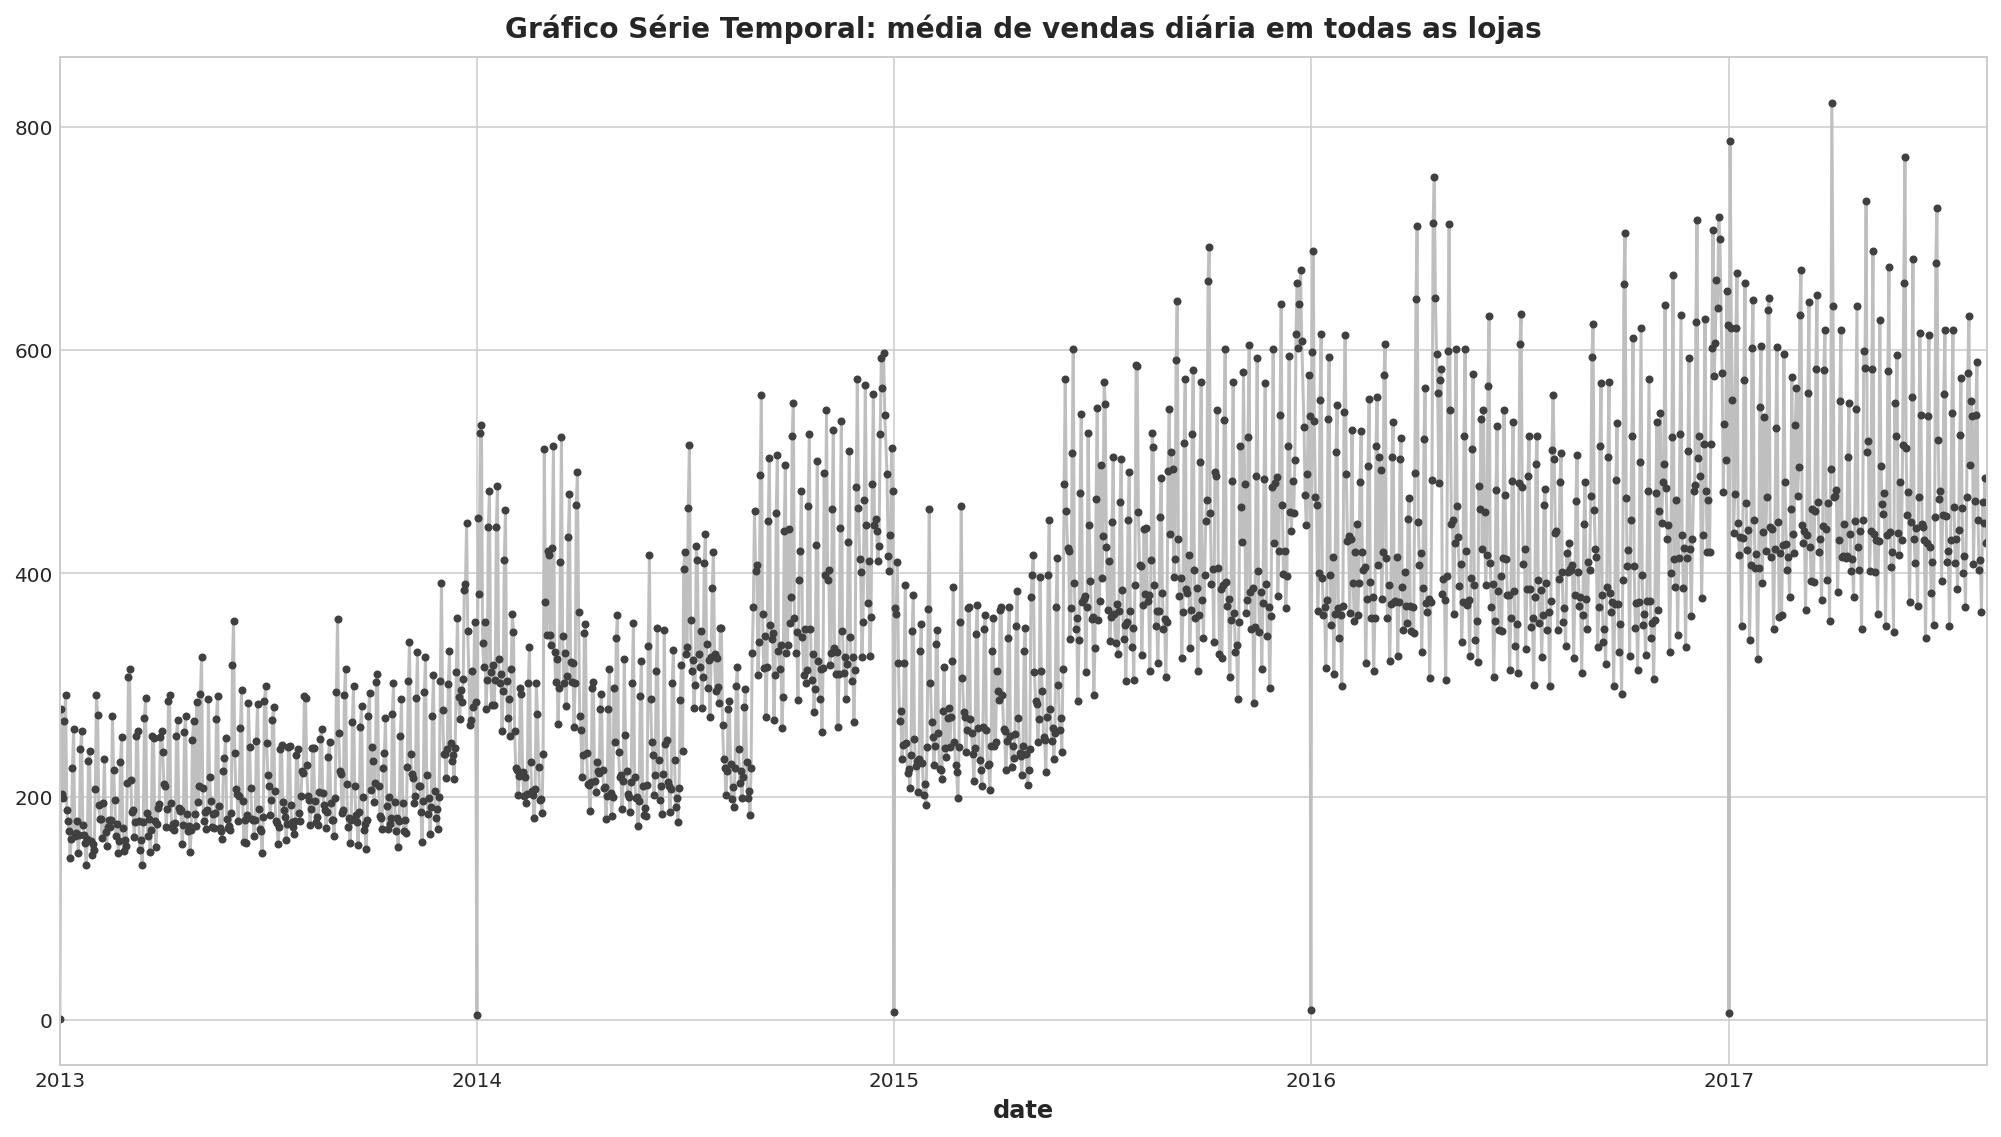

In [10]:
ax = sales.plot(**plot_params)
ax.set_title('Gráfico Série Temporal: média de vendas diária em todas as lojas');

Agora que temos nossa Série Temporal propriamente dita, podemos começar a estudá-la

In [11]:
sales.index

PeriodIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
             '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
             '2013-01-09', '2013-01-10',
             ...
             '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
             '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
             '2017-08-14', '2017-08-15'],
            dtype='period[D]', name='date', length=1684)

### Criando uma Time Step Feature

Para criar uma time step feature, dispomos de dois métodos: usando o pandas, ou usando o statsmodel

In [12]:
# statsmodels

from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=sales.index,  # 
    constant=True,       # 
    order=2,             # 
    drop=True,           # 
)

X = dp.in_sample()

X.head()

,const,trend,trend_squared
date,,,
2013-01-01,1.0,1.0,1.0
2013-01-02,1.0,2.0,4.0
2013-01-03,1.0,3.0,9.0
2013-01-04,1.0,4.0,16.0
2013-01-05,1.0,5.0,25.0


In [13]:
# pandas

df_sales = sales.to_frame() #transformamos a série temporal em um dataframe para utilizamos as funções do pandas 

time_dummy = np.arange(len(df_sales))

df_sales['time'] = time_dummy

X = df_sales.loc[:,['time']] # nossas features 

X.head()

,time
date,
2013-01-01,0
2013-01-02,1
2013-01-03,2
2013-01-04,3
2013-01-05,4


### Montando uma Regressão Linear

Para montarmos uma Regressão Linear, temos que identificar o X (features) e o y (target) que compõe nossos dados, nesse caso temos:

- X = time_dummy criado (e futuramente, outras features)

- y = valores de nossa série temporal

In [14]:
# Declarando cada um dos valores 

y = df_sales['sales'] # target

In [15]:
# montando a regressão
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X,y) # ajustando os parâmetros do modelo (treinando o modelo)

# montando a reta da regressão
y_pred = pd.Series(model.predict(X), index=X.index)


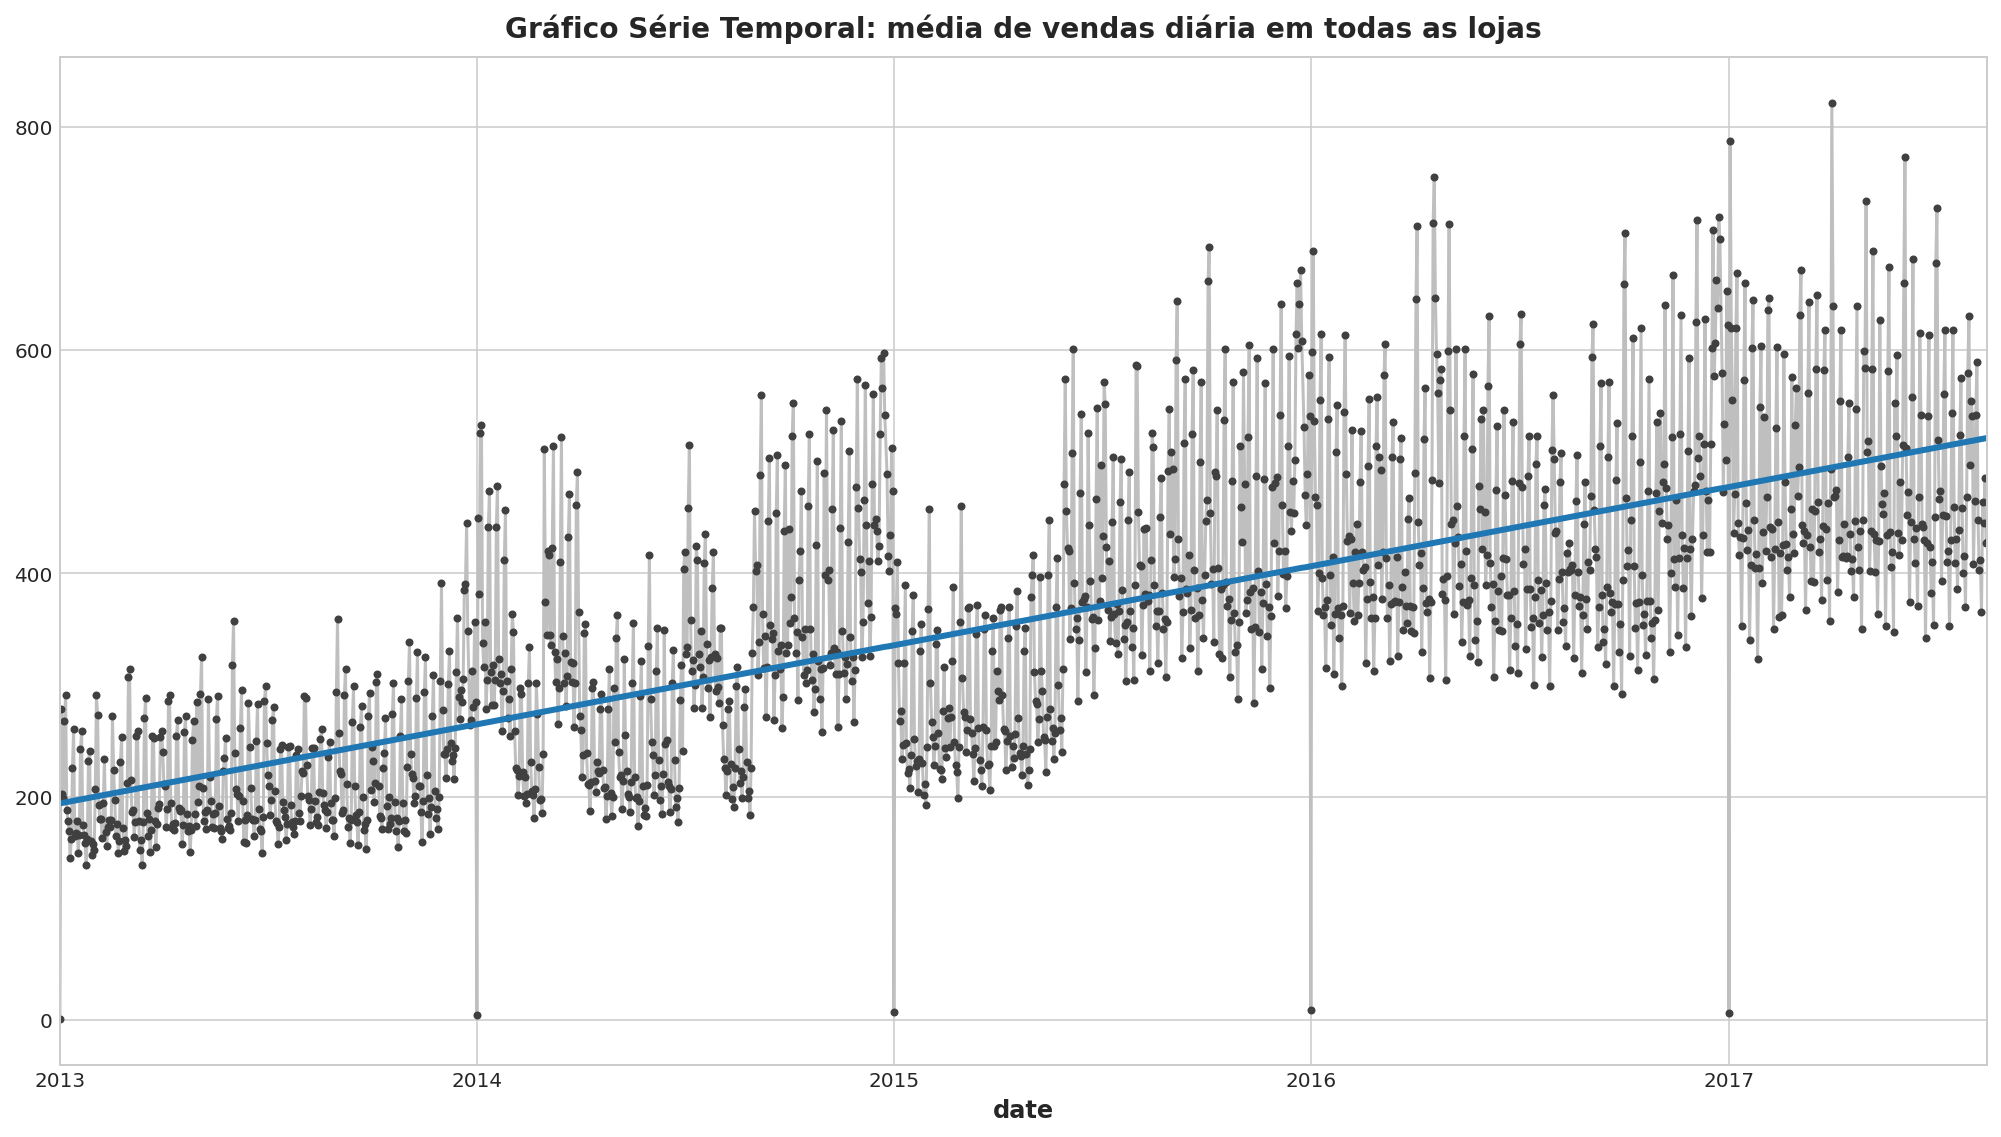

In [16]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Gráfico Série Temporal: média de vendas diária em todas as lojas');

### Lag Feature 

Para criar uma lag feature, utilizamos a função shift do pandas

In [17]:
df = sales.to_frame() # assim como no time step, transformamos em dataframe para acessar as funções do pandas 

lag_1 = df['sales'].shift(1)

df['lag_1'] = lag_1  

df.head()


,sales,lag_1
date,,
2013-01-01,1.409438,NaN
2013-01-02,278.390807,1.409438
2013-01-03,202.840197,278.390807
2013-01-04,198.911154,202.840197
2013-01-05,267.873244,198.911154


### Montando a Regressão da Lag Feature

Assim como anteriormente, para realizar a regressão linear, montamos o X e y para o modelo, desta vez, teremos a seguinte configuração:

- X = Lag features (podemos ter mais de uma)
- y = valores de nossa série temporal

In [18]:
# Separando as variáveis

X = df.loc[:, ['lag_1']].dropna()  
y = df.loc[:, 'sales']  
y, X = y.align(X, join='inner') 


# montando o modelo de regressão linear 
model = LinearRegression()
model.fit(X,y)


# montando a reta da regressão
y_pred = pd.Series(model.predict(X), index=X.index)

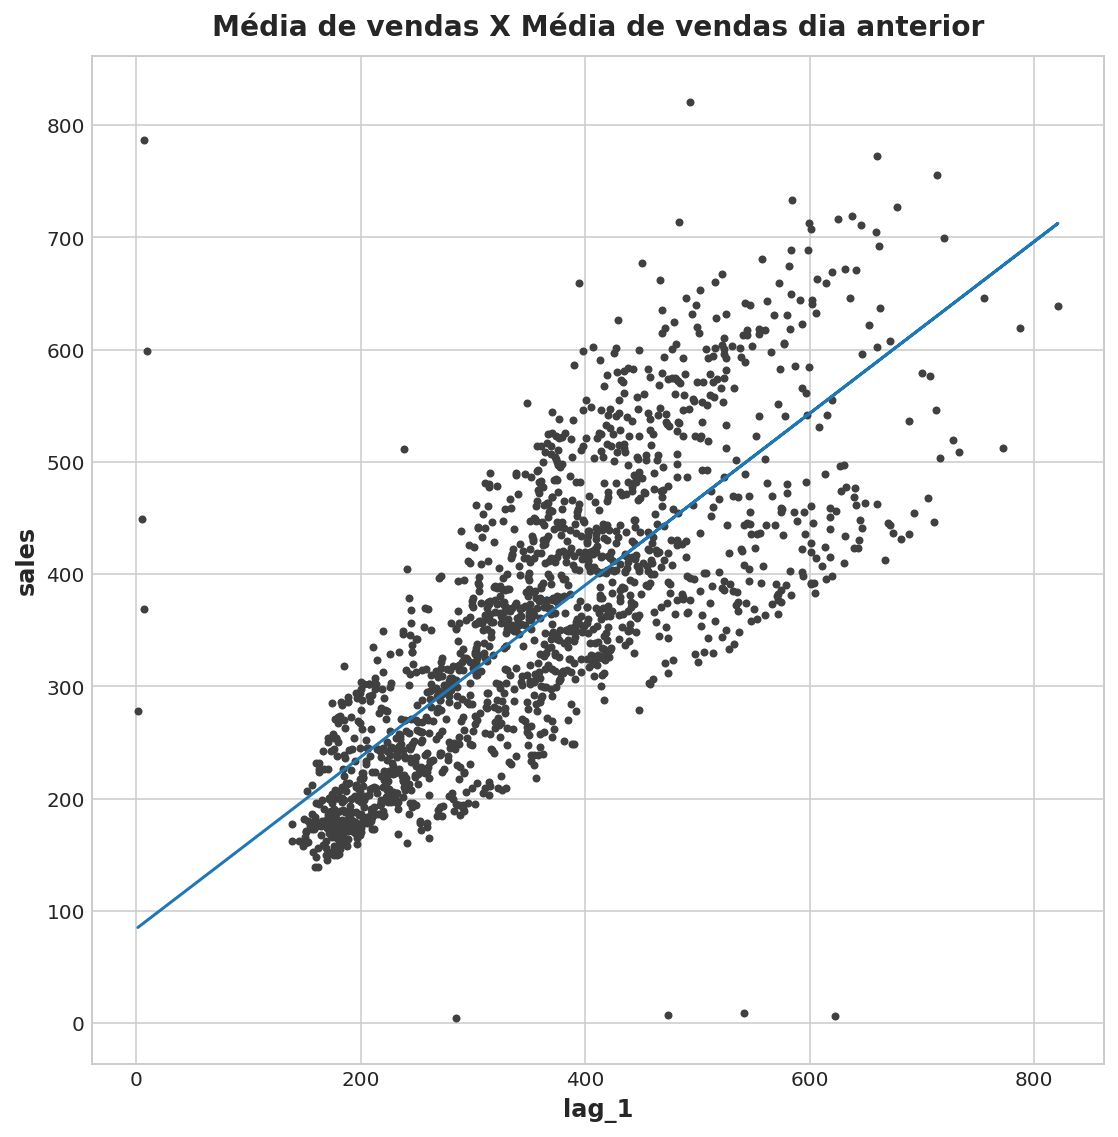

In [19]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Média de vendas X Média de vendas dia anterior');

### Tendência com Média Móvel

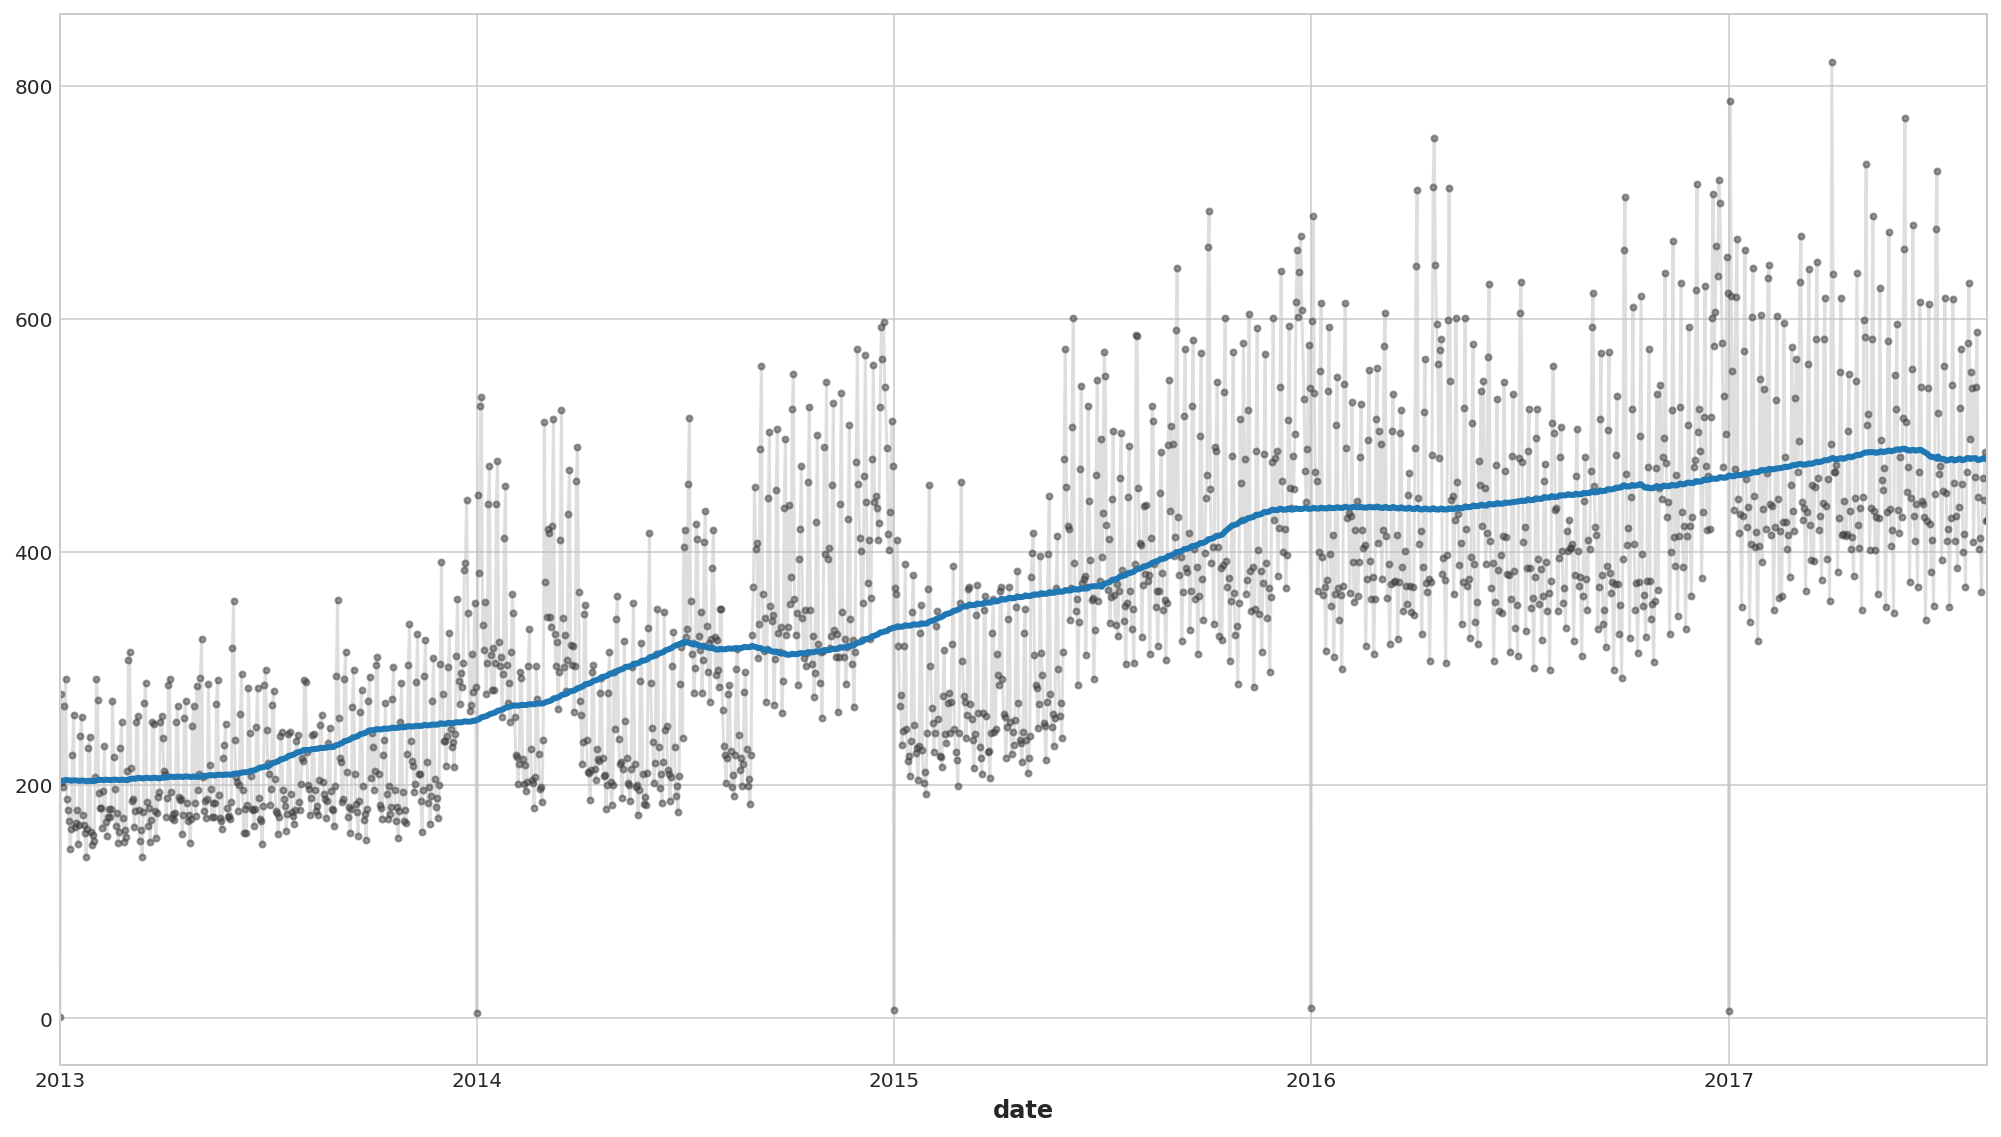

In [20]:
trend = sales.rolling(
    window=365,
    center=True,
    min_periods=40,
).mean()

ax = sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

### Contraste Média com window grande X Média com window pequena

Quando diminuimos o tamanho da janela de valores que a janela compõe, pode-se notar que média com menos janela (janela rápida) tem seus valores alterados com mais facilidade do que a média "lenta".

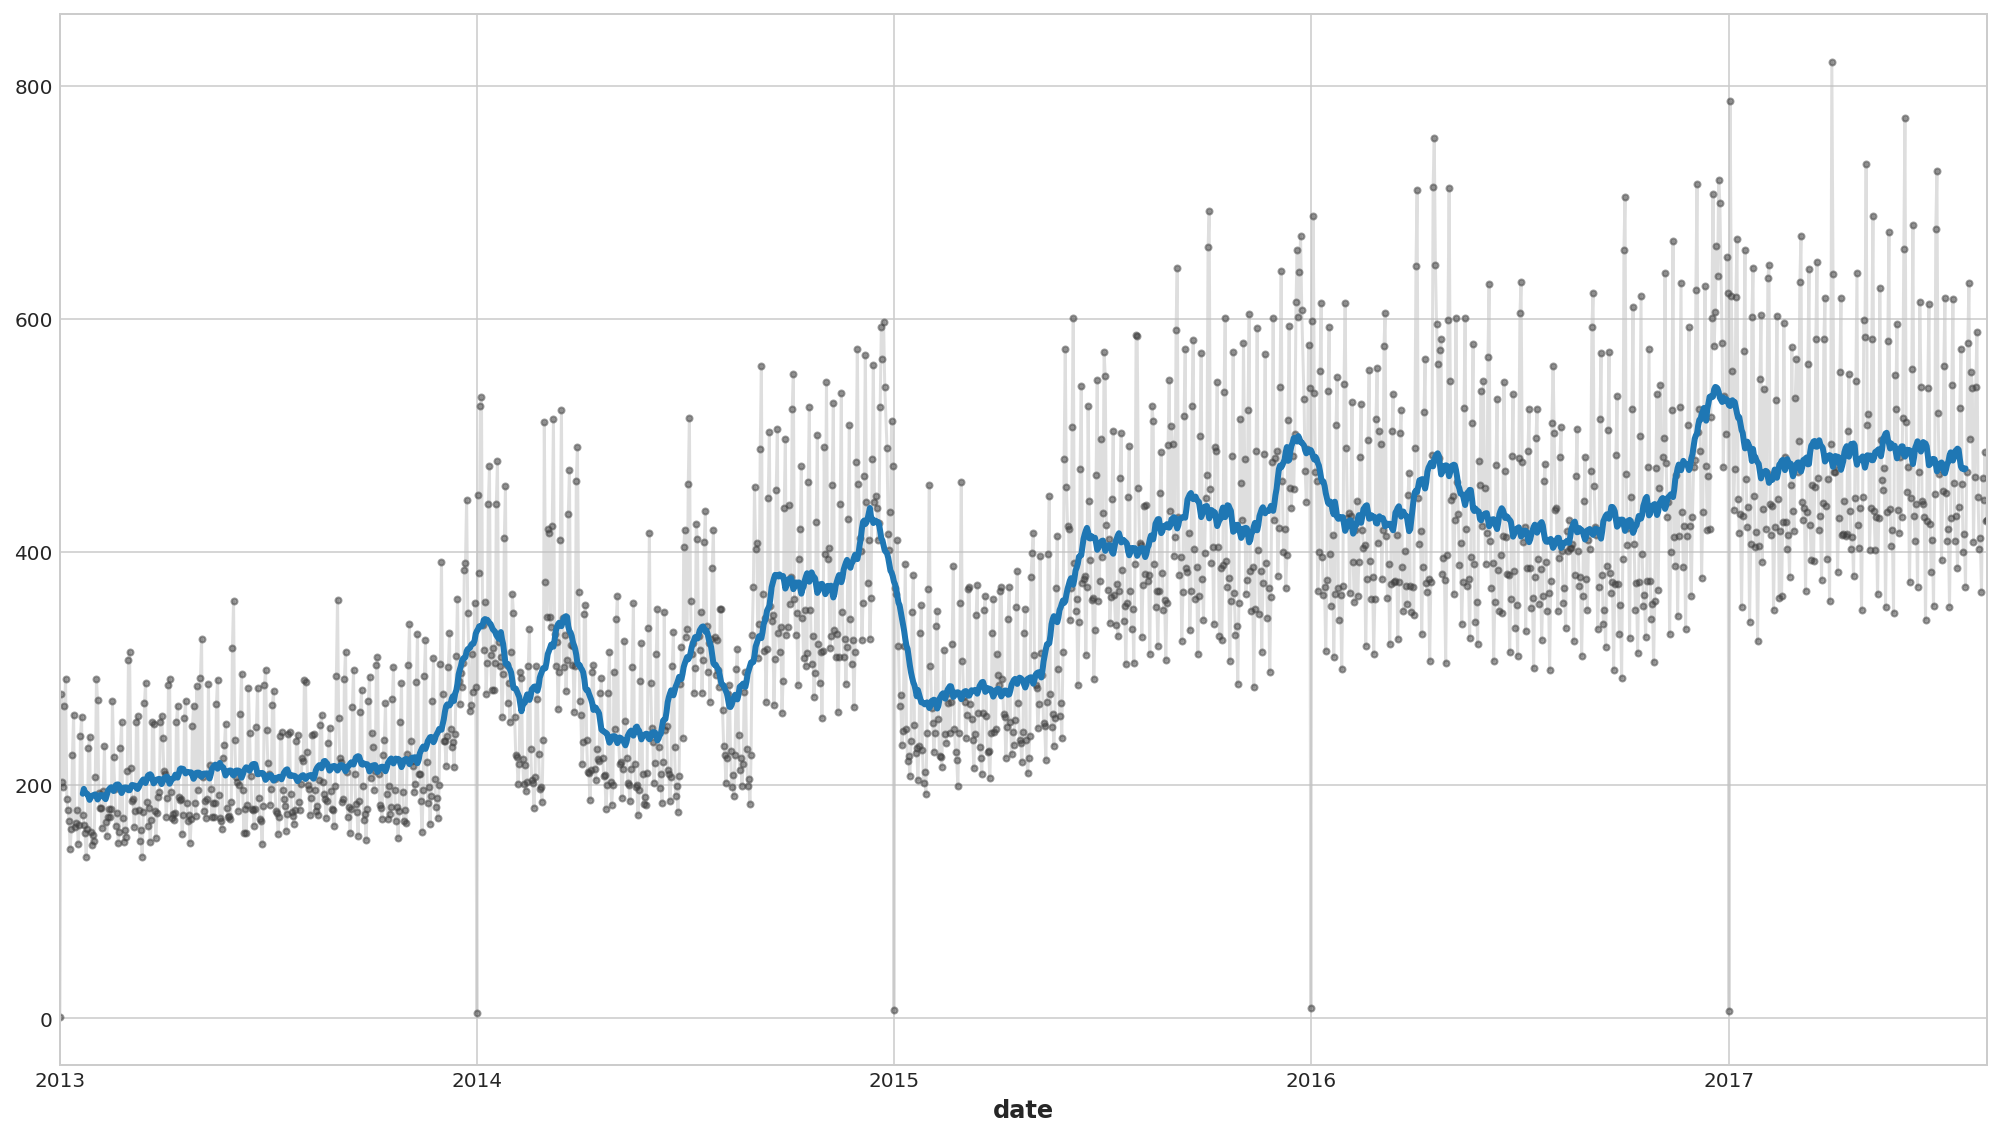

In [21]:
trend = sales.rolling(
    window=40,
    center=True,
    min_periods=40,
).mean()

ax = sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

### Análise da Sazonalidade

### Montando um indicador sazonal

In [22]:
dp = DeterministicProcess(
    index=sales.index,
    constant=True,
    order=1,
    seasonal = True, #!!!!!!
    drop=True,
)
X = dp.in_sample()

X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)"
date,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0


## Utilizando os indicadores sazonais e time dummies para criar uma predição

Após ver esses conceitos, podemos perceber que essas features criadas (time dummies, indicadores sazonais, fourier features e etc.) são são inseridas como entrada para os nossos modelos, de forma a realizar predições (ou forecasts, quando nos tratamos de time series). Veja a seguir um exemplo de utilização de features para predições usando regressão linear.

In [23]:
from statsmodels.tsa.deterministic import CalendarFourier

fourier = CalendarFourier(freq="M", order=10)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal = True,
    additional_terms = [fourier],
    drop=True,
)
X = dp.in_sample()

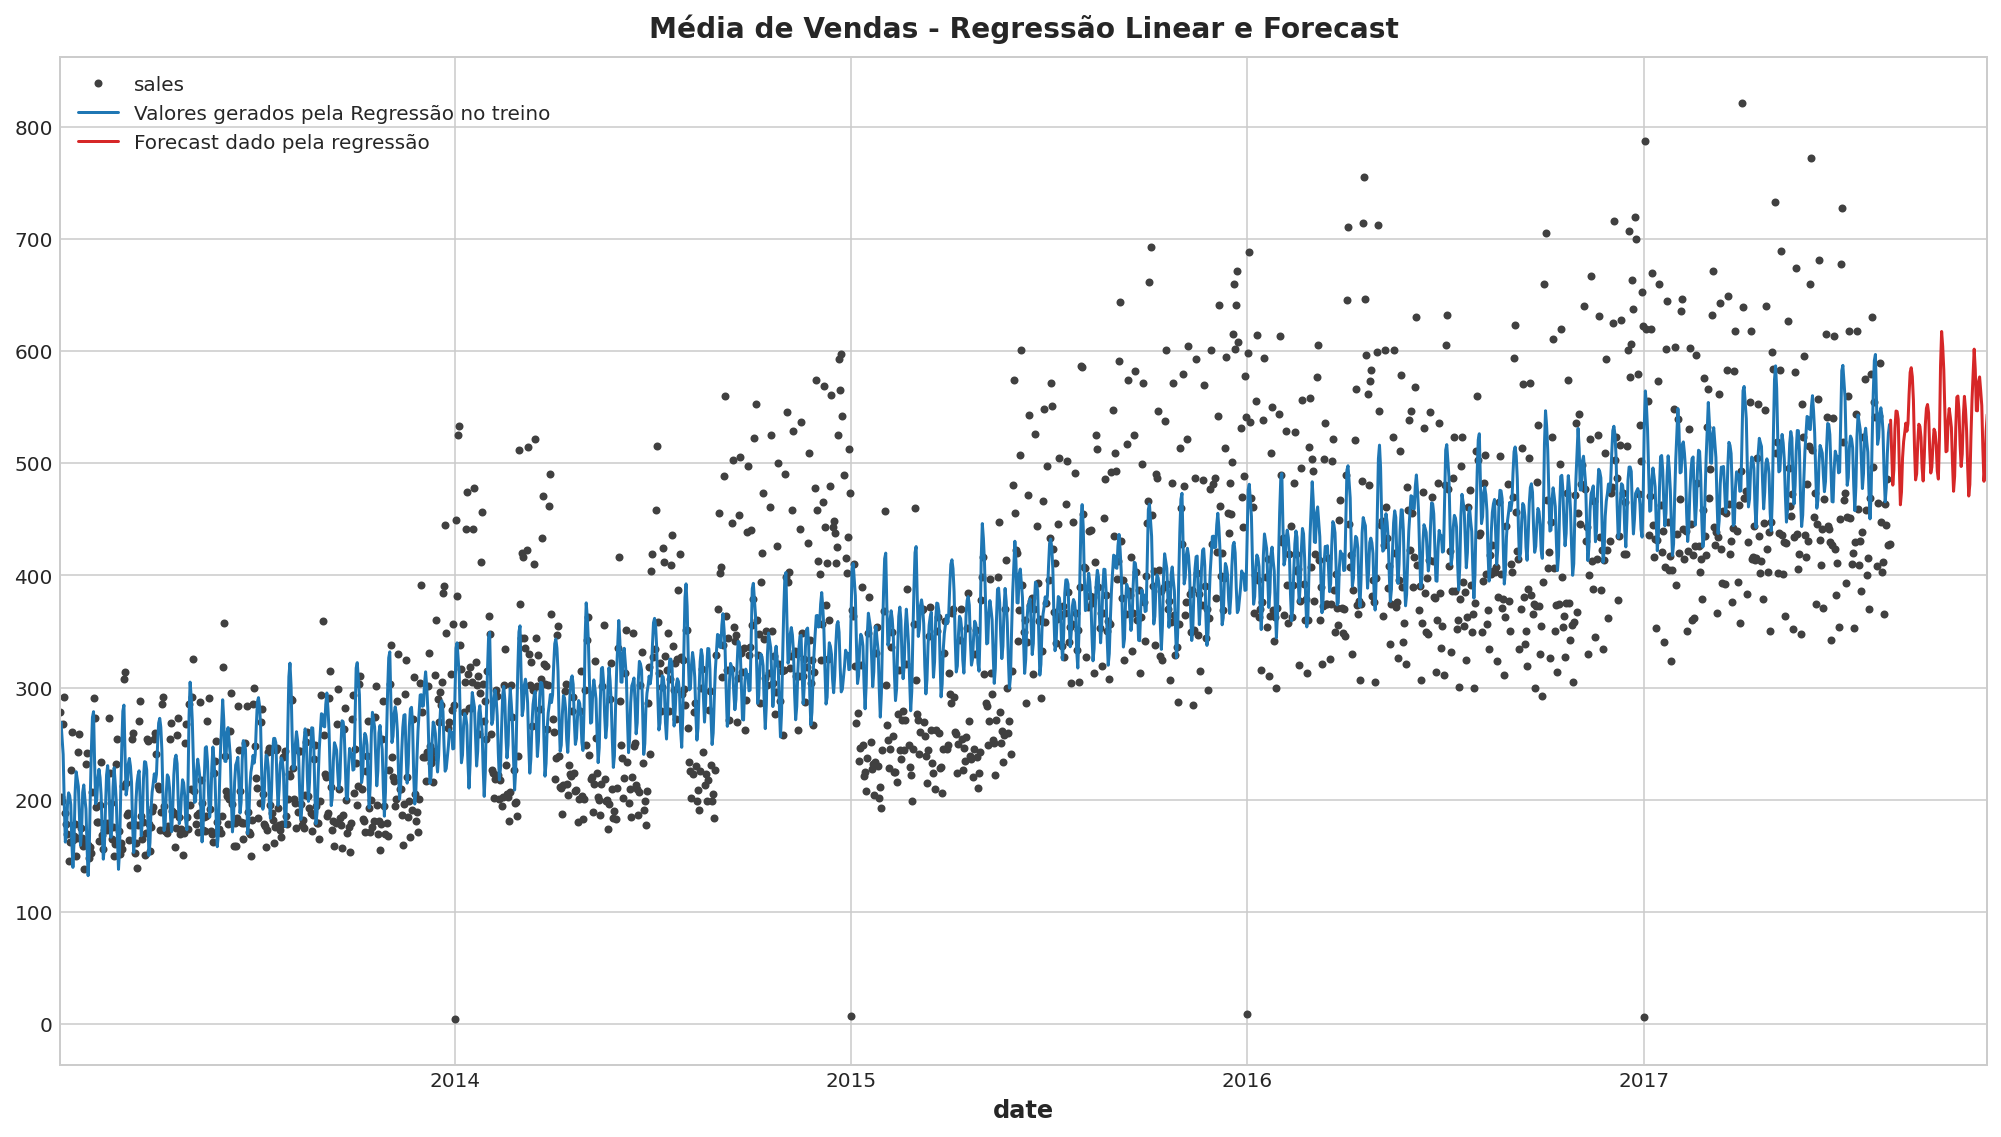

In [24]:
y = sales.copy()[1:]

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Média de Vendas - Regressão Linear e Forecast")
ax = y_pred.plot(ax=ax, label="Valores gerados pela Regressão no treino")
ax = y_fore.plot(ax=ax, label="Forecast dado pela regressão", color='C3')
ax.legend()
plt.show()

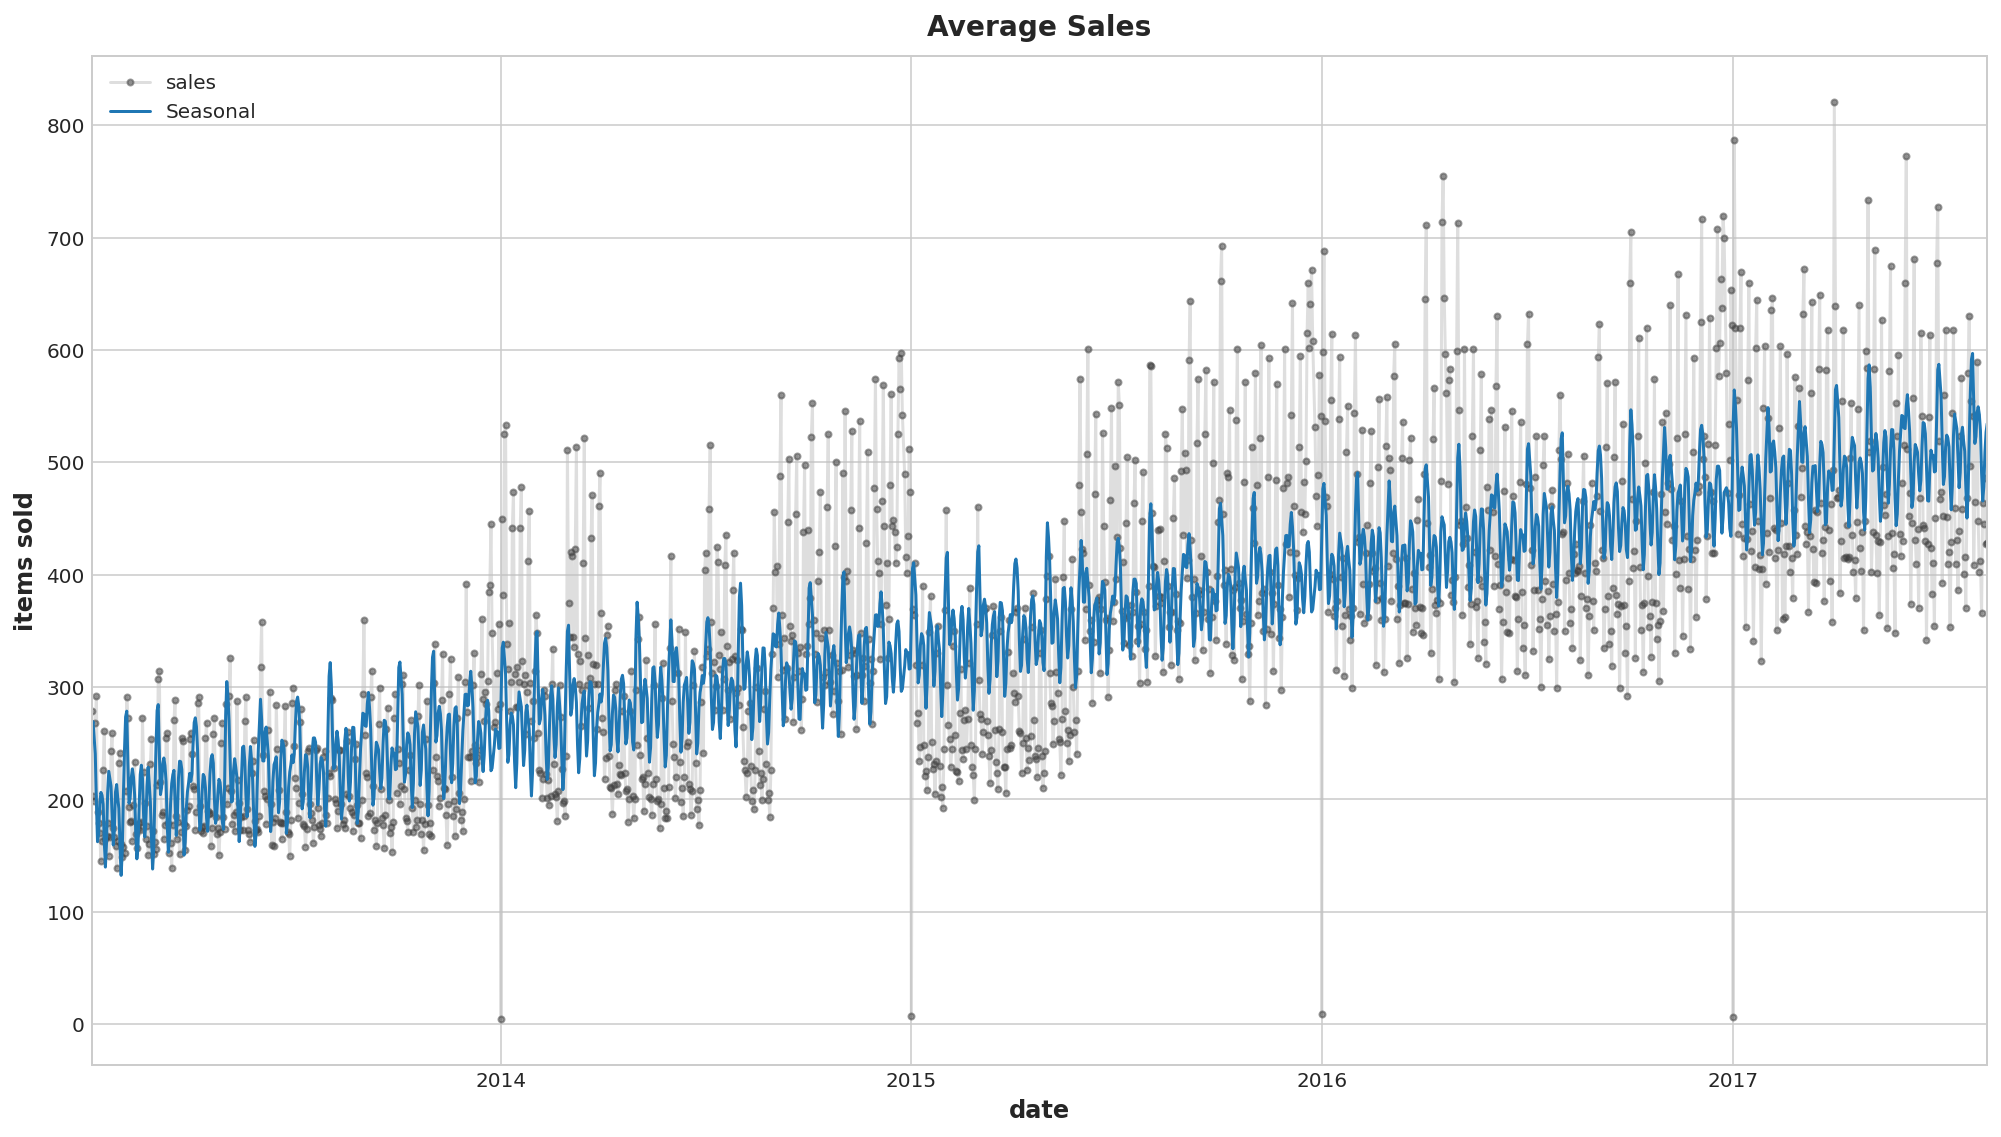

In [25]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

### Dica rápida para visualização de séries temporais

Existem infinitas bibliotecas e métodos para a visualização de séries temporais, uma já usei bastante é a seasonal decompose, do statsmodels. Ela quebra sua série temporal em Tendência, Sazonalidade e Resíduo, como pode ser vista a seguir

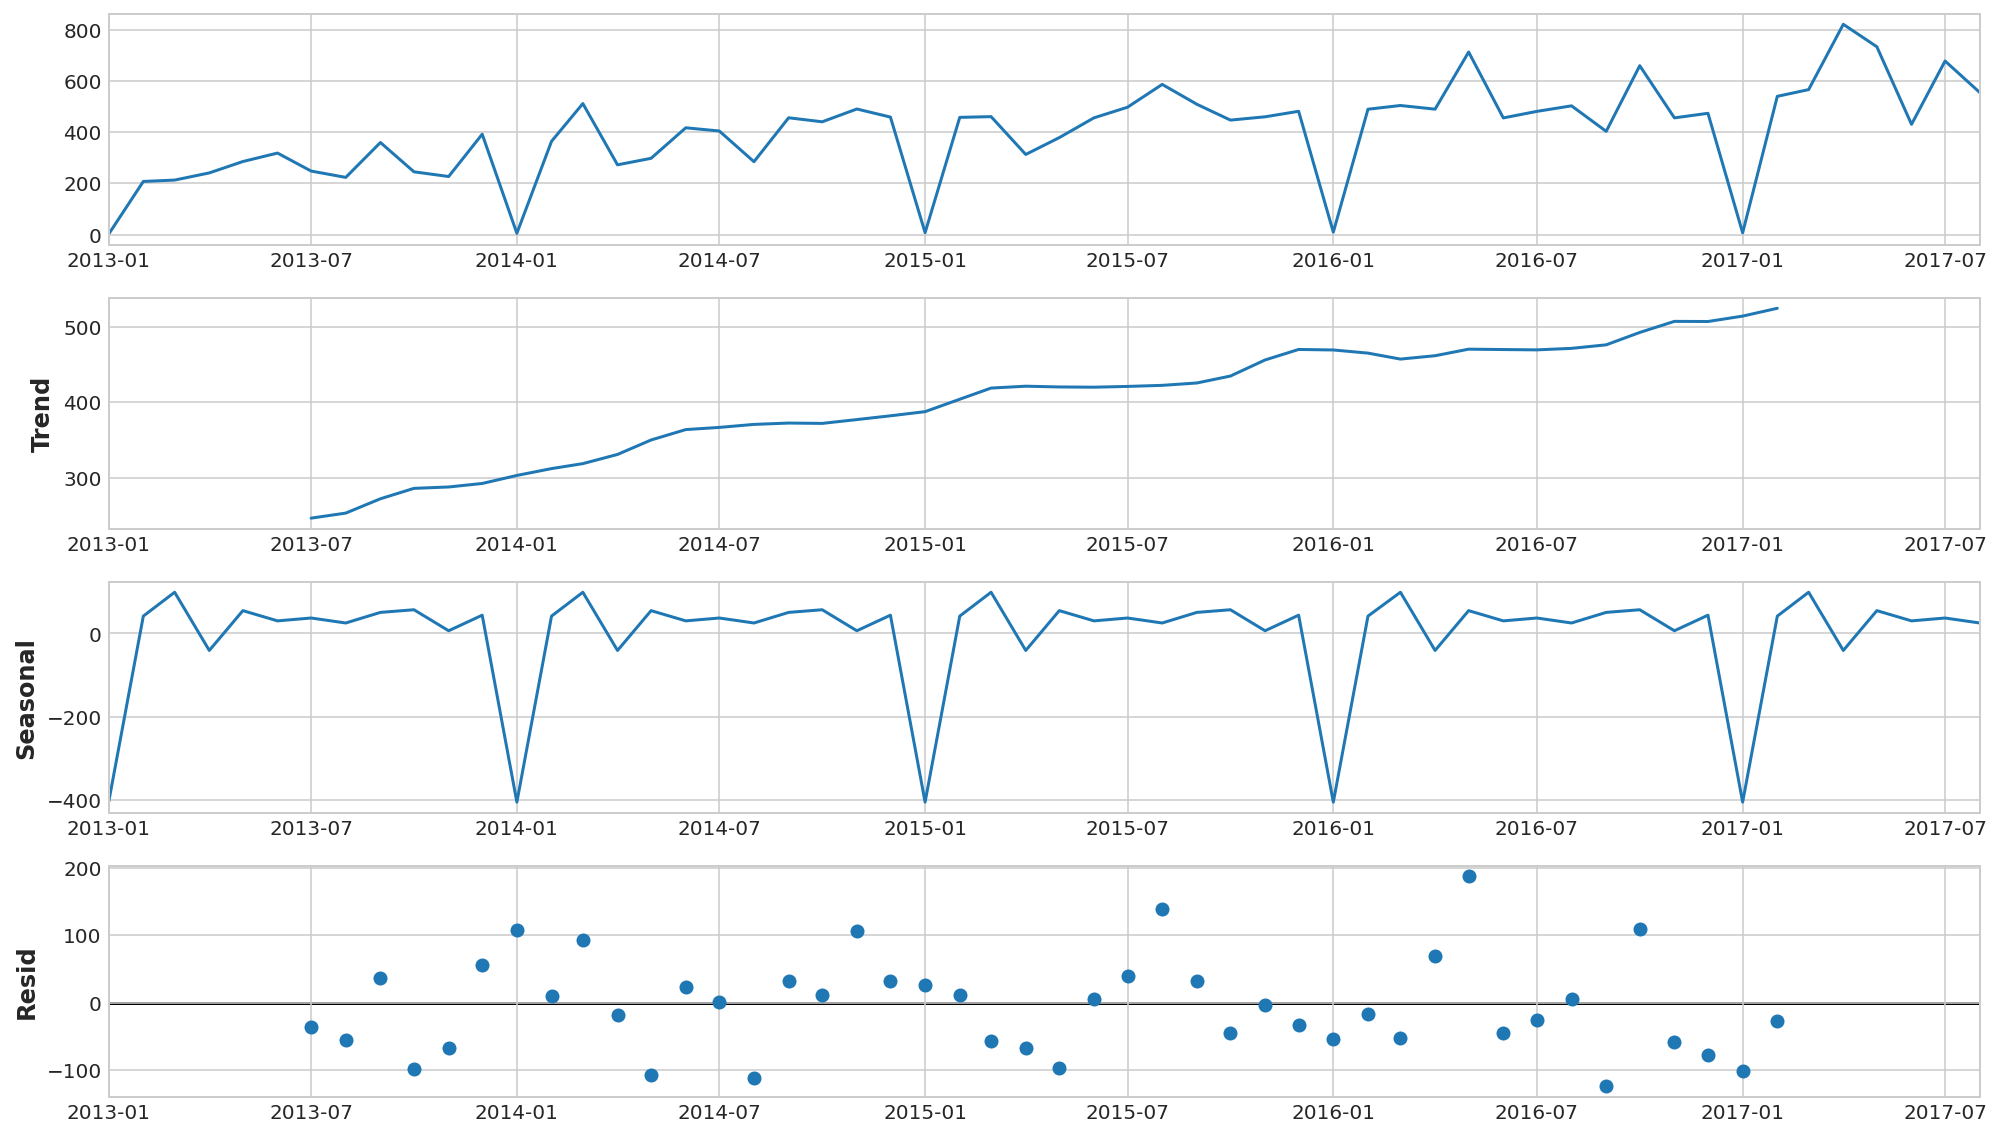

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

series = sales.copy()
series.index = series.index.to_timestamp()
series = series.to_frame()

decompose_result_mult = seasonal_decompose(series.asfreq('MS'), model='additive')

decompose_result_mult.plot()
plt.show()